In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd
import polars as pl # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/best.pt/pytorch/best.pt/1/besty.pt
/kaggle/input/atmosphericphysics/pytorch/20240501-001/1/20240501-001.pth
/kaggle/input/leap-atmospheric-physics-ai-climsim/sample_submission.csv
/kaggle/input/leap-atmospheric-physics-ai-climsim/train.csv
/kaggle/input/leap-atmospheric-physics-ai-climsim/test.csv


# File Paths and Chunk Size

- set file path for train set and test set
- read training dataset with chunks as its large file

In [2]:
# 文件路径
train_csv = '/kaggle/input/leap-atmospheric-physics-ai-climsim/train.csv'
test_csv = '/kaggle/input/leap-atmospheric-physics-ai-climsim/test.csv'

read_chunk_size = 50000 # 一次性读取50000行数据

- read data from csv file and get the 1st chunk

In [3]:
# 读取数据
%time
train_chunks = pd.read_csv(train_csv, chunksize = read_chunk_size)
train_data = next(train_chunks)
train_data = next(train_chunks)
train_data.shape

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.68 µs


(50000, 925)

# Split training set

1. split into input and output
2. split into 
    - training set
    - validation set
    - testing set

In [4]:
# 划分数据集
cols = train_data.columns

def split_io(dframe, in_cols = cols[1:557], out_cols = cols[557:]):
    # 划分输入输出
    in_df = dframe[in_cols]
    out_df = dframe[out_cols]
    return in_df, out_df

def split_tvt(dframe, ratio=[0.8], shuffle=False):
    # 设定好 train (和 val) 集的比例，剩余的均归到test/val
    assert sum(ratio) <= 1, "Ratio sum for train and val cannot be bigger than 1"
    assert len(ratio) > 0, "Ratio cannot be empty"
     # 根据是否需要测试集来调整比例
    train_rat = ratio[0]
    val_rat = (1 - train_rat) if len(ratio) == 1 else ratio[1]
    test_rat = (1 - train_rat - val_rat) if len(ratio) == 2 else 0
    
    data_size = dframe.shape[0]
    train_size = int(data_size * train_rat)
    val_size = (data_size - train_size) if len(ratio) == 1 else int(data_size * val_rat)
    
    if shuffle:
        dframe = dframe.sample(frac=1).reset_index(drop=True)
        
    train = dframe.iloc[:train_size]
    val = dframe.iloc[train_size:train_size + val_size]
    
    if test_rat != 0:
        test = dframe.iloc[train_size + val_size:]
        return train, val, test
    else:
        return train, val


In [5]:
# 划分数据集
train_set, val_set, test_set = split_tvt(train_data, [0.7, 0.2], True)
train_in, train_out = split_io(train_set)
val_in, val_out = split_io(val_set)
test_in, test_out = split_io(test_set)

print(f'{val_set.shape = }')
print(f'{test_set.shape = }')
print(f'{train_in.shape = }')
print(f'{train_out.shape = }')
print(f'{val_in.shape = }')
print(f'{val_out.shape = }')
val_out.iloc[0]

val_set.shape = (10000, 925)
test_set.shape = (5000, 925)
train_in.shape = (35000, 556)
train_out.shape = (35000, 368)
val_in.shape = (10000, 556)
val_out.shape = (10000, 368)


ptend_t_0       -1.417721e-05
ptend_t_1       -1.757781e-05
ptend_t_2       -2.211645e-05
ptend_t_3       -4.901950e-05
ptend_t_4       -8.215995e-05
                     ...     
cam_out_PRECC    1.585164e-07
cam_out_SOLS     0.000000e+00
cam_out_SOLL     0.000000e+00
cam_out_SOLSD    0.000000e+00
cam_out_SOLLD    0.000000e+00
Name: 35000, Length: 368, dtype: float64

# Convert Data

Rearrange data with 60 dimensions into 2d tensor($n \times 60$) and data with 1 dimension into a 1d tensor($m \times 1$). 

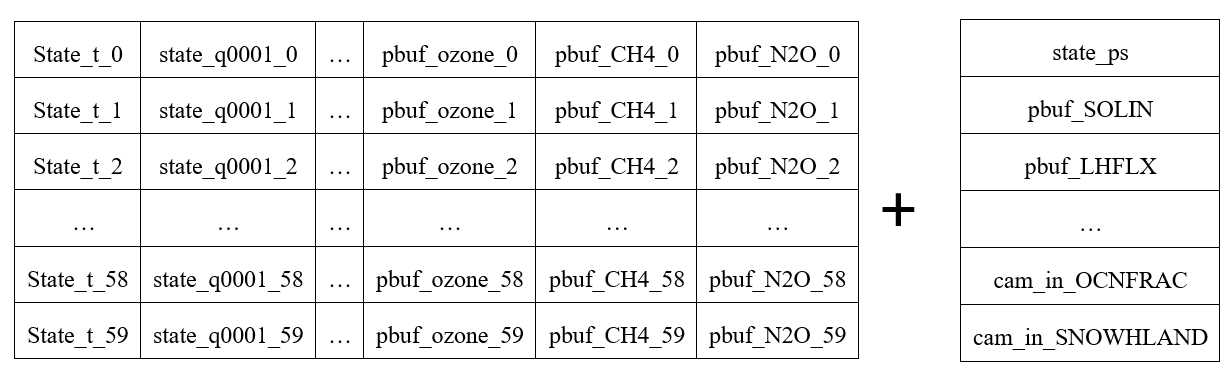  

<!-- <font color='red'>Un-comment images to see</font> -->

This is what input data look like

---

After test, the input has (16,1) and (9, 60), the output has (8,1) and (6, 60)

In [6]:
import re

# 转换数据集
def convert_data(cols, line):
    # 输入一个表头和一行的数据，将其转换为两个张量
    tensor1d = [[],[]]
    tensor2d = [[],[]]
    old_title = ''
    for col, value in zip(cols, line):
        match = re.search(r'_(\d+)$', col)
        if match is None: # in 1d tensor
            tensor1d[0].append(col)
            tensor1d[1].append([value])
        else:
            title = col[:-len(match.group(0))]
            if not title == old_title:
                old_title = title
                tensor2d[0].append(title)
                tensor2d[1].append([])
            tensor2d[1][-1].append(value)
    tensor1d[0] = np.array(tensor1d[0])
    tensor2d[0] = np.array(tensor2d[0])
    tensor1d[1] = np.array(tensor1d[1])
    tensor2d[1] = np.array(tensor2d[1])
    return tensor1d, tensor2d
        
d1, d2 = convert_data(val_out.columns, val_out.iloc[0]) # 测试一行
print(f'{d1[0].shape = }\t{d1[0].dtype = }')
print(f'{d1[1].shape = }\t{d1[1].dtype = }')
print(f'{d2[0].shape = }\t{d2[0].dtype = }')
print(f'{d2[1].shape = }\t{d2[1].dtype = }')

d1[0].shape = (8,)	d1[0].dtype = dtype('<U14')
d1[1].shape = (8, 1)	d1[1].dtype = dtype('float64')
d2[0].shape = (6,)	d2[0].dtype = dtype('<U11')
d2[1].shape = (6, 60)	d2[1].dtype = dtype('float64')


# Dataset

Define a custom dataset for this input/output

In [7]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

class MyDataset(Dataset):
    def __init__(self, dsin, dsout, transform=transforms.Compose([
        transforms.ToTensor(),
    ])):
        self.dsin = dsin
        self.dsout = dsout
        self.transform =transform
    
    def __len__(self):
        return self.dsin.shape[0]
    
    def __getitem__(self, x):
        in1, in2 = convert_data(self.dsin.columns, self.dsin.iloc[x])
        out1, out2 = convert_data(self.dsout.columns, self.dsout.iloc[x])
        din = [in1[1], in2[1]]
        dout = [out1[1], out2[1]]
        
        if self.transform:
            din[0] = self.transform(din[0])
            din[1] = self.transform(din[1])
            dout[0] = self.transform(dout[0])
            dout[1] = self.transform(dout[1])
        
        # 使用torch.unsqueeze将数组从[m, n]转换为[1, m, n]
#         din = [torch.from_numpy(tensor) for tensor in din]
#         dout = [torch.from_numpy(tensor) for tensor in dout]
        din = [tensor.to(torch.float32) for tensor in din]
        dout = [tensor.to(torch.float32)  for tensor in dout]
        
        return din, dout

In [18]:
batch_size = 200
num_workers = 128
lr = 0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
train_dataset = MyDataset(train_in, train_out)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
print(f'{len(train_dataset) = }')

val_dataset = MyDataset(val_in, val_out)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
print(f'{len(val_dataset) = }')

len(train_dataset) = 35000
len(val_dataset) = 10000


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 128 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
# val_dataset[0]

# Build model

Model structure is like this

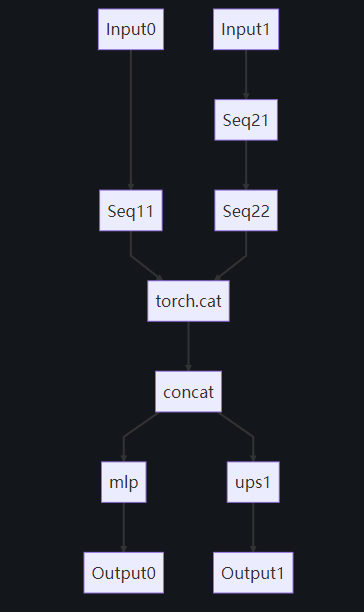

```mermaid
graph 

A[Input0] ---> B[Seq11] --> C[torch.cat]
D[Input1] --> E[Seq21] --> F[Seq22] --> C
C --> G[concat] --> H[mlp] --> I[Output0]
G --> J[ups1] --> K[Output1]
```

In [11]:
import torch.nn as nn
import torch.nn.functional as F

def bilinear_kernel(in_channels, out_channels, kernel_size):
    if type(kernel_size) != tuple:
        factor = (kernel_size + 1) // 2
        if kernel_size % 2 == 1:
            center = factor - 1
        else:
            center = factor - 0.5
        og = (torch.arange(kernel_size[0]).reshape(-1, 1),
              torch.arange(kernel_size[1]).reshape(1, -1))
        filt = (1 - torch.abs(og[0] - center) / factor) * \
               (1 - torch.abs(og[1] - center) / factor)
        weight = torch.zeros((in_channels, out_channels,
                              kernel_size, kernel_size))
        weight[range(in_channels), range(out_channels), :, :] = filt
    else:
        factor1 = (kernel_size[0] + 1) // 2
        factor2 = (kernel_size[1] + 1) // 2
        if kernel_size[0] % 2 == 1:
            center1 = factor1 - 1
        else:
            center1 = factor1 - 0.5
        if kernel_size[1] % 2 == 1:
            center2 = factor2 - 1
        else:
            center2 = factor2 - 0.5
        og = (torch.arange(kernel_size[0]).reshape(-1, 1),
              torch.arange(kernel_size[1]).reshape(1, -1))
        filt = (1 - torch.abs(og[0] - center1) / factor1) * \
               (1 - torch.abs(og[1] - center2) / factor2)
        weight = torch.zeros((in_channels, out_channels,
                              kernel_size[0], kernel_size[1]))
        weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

class TransConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, 
                 kernel_size, stride=1, padding=0):
        super(TransConv, self).__init__()
        self.trans_conv = nn.ConvTranspose2d(in_channels, out_channels, 
                 kernel_size, stride, padding)
        self.trans_conv.weight.data.copy_(bilinear_kernel(in_channels, out_channels, kernel_size))
        
    def forward(self, x):
        return self.trans_conv(x)
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.seq11 = nn.Sequential( # 1, 16, 1
            nn.Conv2d(1, 16, 3, padding=(1, 2)), # 16, 16, 3
            nn.Conv2d(16, 32, 5, padding=(2, 3)), # 32, 16, 5
            nn.MaxPool2d((2,1)), # 32, 8, 5
            nn.ReLU(),
            nn.Conv2d(32, 64, 5, padding=(2, 4)),
            nn.MaxPool2d(2), 
            nn.ReLU(),
        ) # 64, 4, 4
        
        self.seq21 = nn.Sequential( # 1, 9, 60
            nn.Conv2d(1, 8, 5, padding=3),
            nn.Conv2d(8, 16, 5, padding=3),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(16, 32, 5, padding=3),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        ) # 64, 2, 8
        self.seq22 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=(2,3)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=(2,2)),
            nn.MaxPool2d((1,2)),
            nn.ReLU()
        ) # 256, 4, 4
        
        self.concat = nn.Sequential(
            nn.Conv2d(320, 320, 5, padding=4),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        self.ups1 = nn.Sequential(
            nn.Conv2d(320, 1, 1),
            TransConv(1, 1, (32, 64), padding=(25,8), stride=(8,4)),
        )
        
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(144),
            nn.LazyLinear(84),
            nn.LazyLinear(8),
        )
        
    
    def forward(self, x):
        t1d, t2d = x[0], x[1]
        t1d = self.seq11(t1d)
        t2d = self.seq21(t2d)
        t2d = self.seq22(t2d)
        tsr = torch.cat([t1d,t2d], 1)
        tsr = self.concat(tsr)
        out1 = self.mlp(tsr)
        out1 = torch.unsqueeze(out1, 1)  # 添加一个额外的维度
        out1 = torch.unsqueeze(out1, 3)  # 添加另一个额外的维度
        out2 = self.ups1(tsr)
        out = (out1, out2)      
        return out
    


In [16]:
net = Net().to(device)
net.load_state_dict(torch.load(
    '/kaggle/input/atmosphericphysics/pytorch/20240501-001/1/20240501-001.pth'))
net

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Net(
  (seq11): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 2))
    (1): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 3))
    (2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 4))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
  )
  (seq21): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
    (1): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): MaxPo

In [19]:
import torch.optim as optim

def criterion(pred, target):
    loss1 = torch.mean((pred[0] - target[0])**2)
    loss2 = torch.mean((pred[1] - target[1])**2)
    loss = loss1 + loss2
    return loss
    
optimizer = optim.Adam(net.parameters(), lr=lr)

In [14]:
num_epochs = 10


lowest_loss = float('inf')


In [ ]:
from tqdm import tqdm 
import time


for epoch in range(num_epochs):
    t0 = time.time()
    net.train()
    train_loss = 0.0
    num_train_batches = 0

    for inp, outp in tqdm(train_loader):
        inp, outp = [inps.to(device, non_blocking=True) for inps in inp], [outps.to(device, non_blocking=True) for outps in outp]
        out_h = net(inp)
        crit = criterion(out_h, outp)
        loss = crit.item()
        train_loss += loss
        crit.backward()
        optimizer.step()
        optimizer.zero_grad()
        num_train_batches += 1

    net.eval()
    val_loss = 0.0
    num_val_batches = 0

    with torch.no_grad():
        for inp, outp in tqdm(val_loader):
            inp, outp = [inps.to(device, non_blocking=True) for inps in inp], [outps.to(device, non_blocking=True) for outps in outp]
            out_h = net(inp)
            crit = criterion(out_h, outp)
            val_loss += crit.item()
            num_val_batches += 1

    avg_train_loss = train_loss / num_train_batches
    avg_val_loss = val_loss / num_val_batches

    if avg_val_loss < lowest_loss:
        torch.save(net.state_dict(), 'best.pth')  # 保存模型参数而不是整个模型
        lowest_loss = avg_val_loss

    t1 = time.time()
    print(f'Epoch {epoch} > Time Cost: {t1-t0:.2f}s | Train Loss: {avg_train_loss:.3f} | Val Loss: {avg_val_loss:.3f}')

100%|██████████| 50/50 [00:14<00:00,  3.36it/s]


Epoch 0 > Time Cost: 60.48s | Train Loss: 8493.910 | Val Loss: 1914.525


100%|██████████| 50/50 [00:14<00:00,  3.36it/s]


Epoch 1 > Time Cost: 60.46s | Train Loss: 1809.142 | Val Loss: 2006.004


100%|██████████| 50/50 [00:14<00:00,  3.37it/s]


Epoch 2 > Time Cost: 60.55s | Train Loss: 1588.904 | Val Loss: 1432.259


  0%|          | 0/175 [00:00<?, ?it/s]

In [ ]:
torch.save(net, "net.pt")

# Test Model

In [ ]:
class TestDataset(Dataset):
    def __init__(self, dsin, transform=transforms.Compose([
        transforms.ToTensor(),
    ])):
        self.dsin = dsin
        self.transform =transform
    
    def __len__(self):
        return self.dsin.shape[0]
    
    def __getitem__(self, x):
        in1, in2 = convert_data(self.dsin.columns, self.dsin.loc[x])
        din = [in1[1], in2[1]]
        
        if self.transform:
            din[0] = self.transform(din[0])
            din[1] = self.transform(din[1])
        
        # 使用torch.unsqueeze将数组从[m, n]转换为[1, m, n]
#         din = [torch.from_numpy(tensor) for tensor in din]
        din = [tensor.to(torch.float32) for tensor in din]
        
        return din

In [ ]:
net.load_state_dict(torch.load('/kaggle/working/best.pth'))

In [ ]:
test_dataset = MyDataset(test_in, test_out)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
print(f'{len(test_dataset) = }')

In [ ]:
t0 = time.time()

net.eval()
test_loss = 0.0
num_test_batches = 0

with torch.no_grad():
    for inp, outp in tqdm(test_loader):
        inp, outp = [inps.to(device, non_blocking=True) for inps in inp], [outps.to(device, non_blocking=True) for outps in outp]
        out_h = net(inp)
        crit = criterion(out_h, outp)
        test_loss += crit.item()
        num_test_batches += 1

avg_test_loss = test_loss / num_test_batches

print(f'Test Loss: {avg_test_loss:.3f} | Test Loss: {avg_test_loss:.3f}')